# Covariance and correlation

## Dependence of random variables

If two random variables $X$ and $Y$ are _not_ [independent](independence), then they are called (naturally) _dependent_. Though our goal in this chapter is to study a _particular type_ of dependence between random variables, I think it will benefit us by first discussing dependence in general.

A natural source of examples of dependent random variables are those which are *functionally* dependent in the sense of the following theorem:

```{prf:theorem} Functional dependence $\Rightarrow$ dependence

Let $X$ and $Y$ be random variables. If $Y = h(X)$ for some function $h:\mathbb{R} \to \mathbb{R}$, then $X$ and $Y$ are dependent.
```

In order to prove this, we need to make the (mild) assumption that there is an event $B\subset \mathbb{R}$ with

$$
0<P(Y\in B)<1.
$$ (middle-eqn)

In this case, we set $A = f^{-1}(B)^c$ and observe that

$$
P(X\in A, \ Y\in B) = P(\emptyset) =0.
$$

On the other hand, we have

$$
P(X\in A) = 1 - P(Y\in B),
$$

and so

$$
P(X\in A) P(Y\in B) = (1 - P(Y\in B))P(Y\in B) \neq 0
$$

by {eq}`middle-eqn`. But then

$$
P(X\in A, \ Y\in B) \neq P(X\in A) P(Y\in B),
$$

which proves $X$ and $Y$ are dependent.

What does a pair of functionally dependent random variables look like? For an example, let's suppose that

$$
X \sim \mathcal{N}(1,0.5^2) \quad \text{and} \quad Y = h(X) = X(X-1)(X-2).
$$

Then, let's simulate a draw of 1000 samples from $X$, toss them into

$$
h(x) = x(x-1)(x-2)
$$

to obtain the associated $y$-values, and then produce a scatter plot:

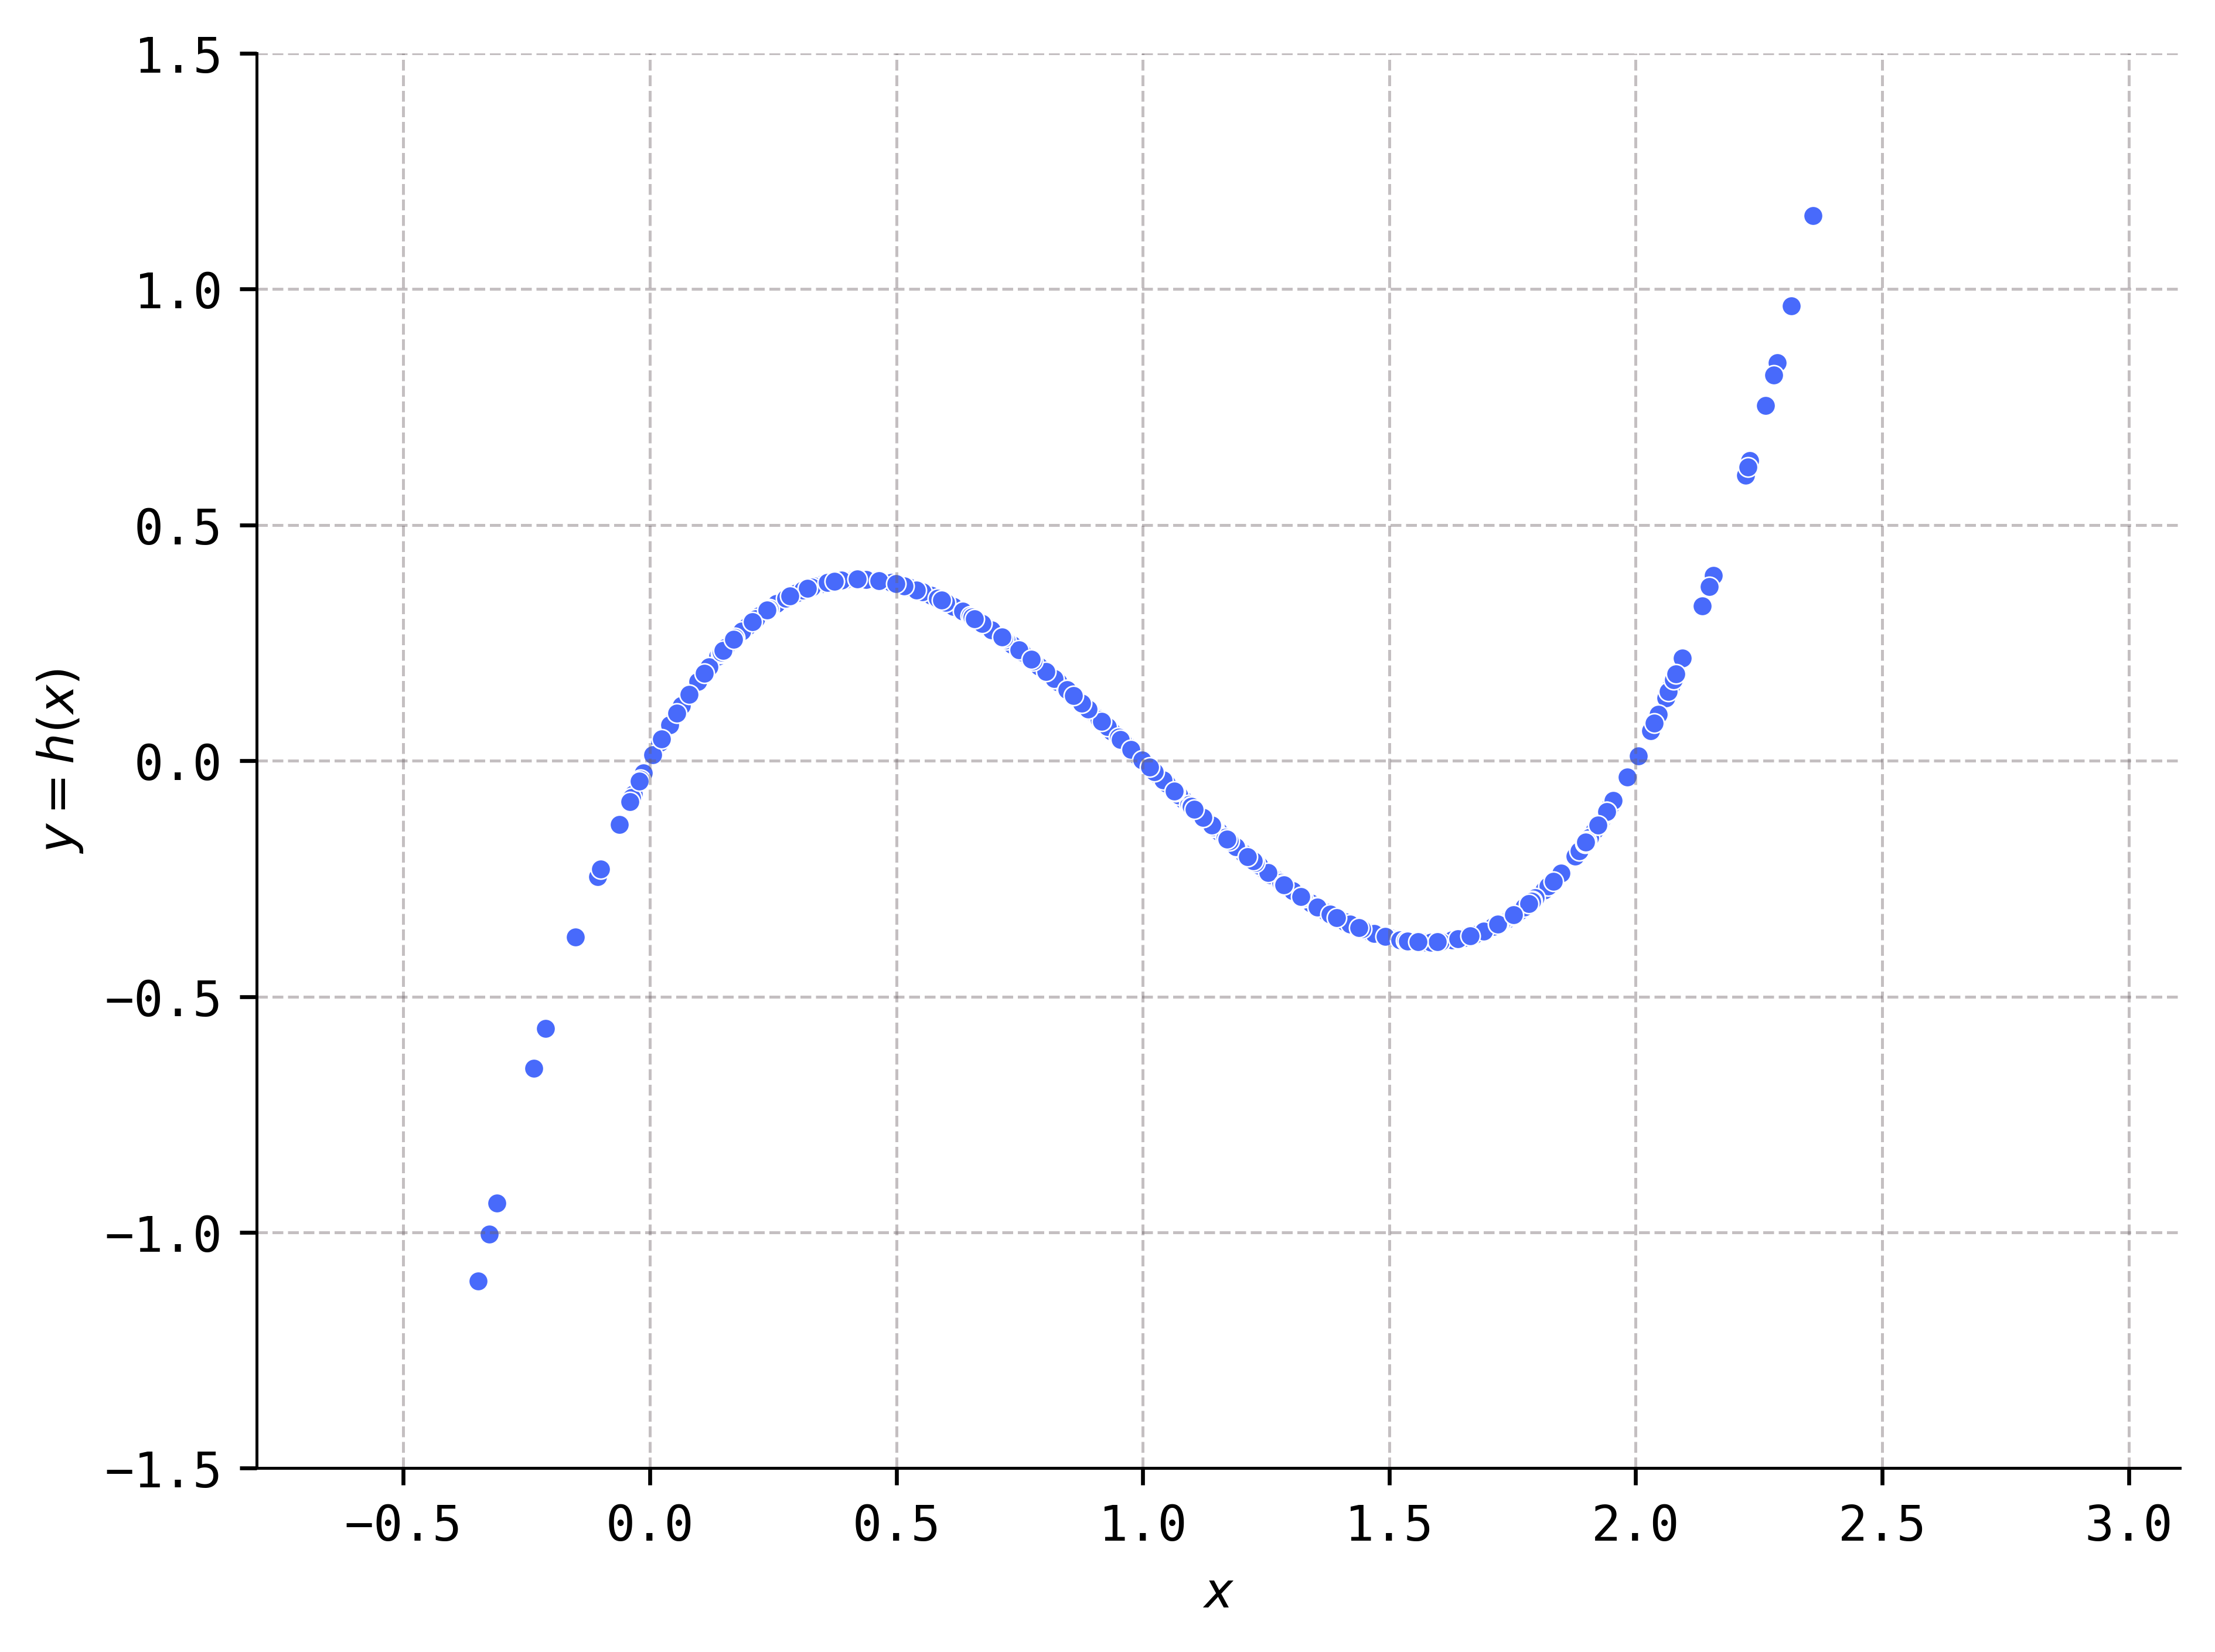

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal, norm

# hide annoying warnings for tight_layout()
import warnings
warnings.filterwarnings("ignore")

# set custom style for plots
plt.style.use('../aux-files/custom_style_light.mplstyle')

# make sure this comes last in the imports!
# change the output resolution and size of figures
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 600

# end import section

np.random.seed(42)

def h(x):
    return x * (x - 1) * (x - 2)

x = norm.rvs(loc=1, scale=0.5, size=1000)
y = h(x)

sns.scatterplot(x=x, y=y)
plt.xlabel('$x$')
plt.ylabel('$y=h(x)$')
plt.ylim(-1.5, 1.5)
plt.tight_layout()

The plot looks exactly like we would expect: A bunch of points lying on the graph of the function $y=h(x)$.

However, very often with real-world data, an **exact** functional dependence $Y = h(X)$ does not truly hold. Instead, the functional relationship is "noisy", resulting in scatter plots that look like this:

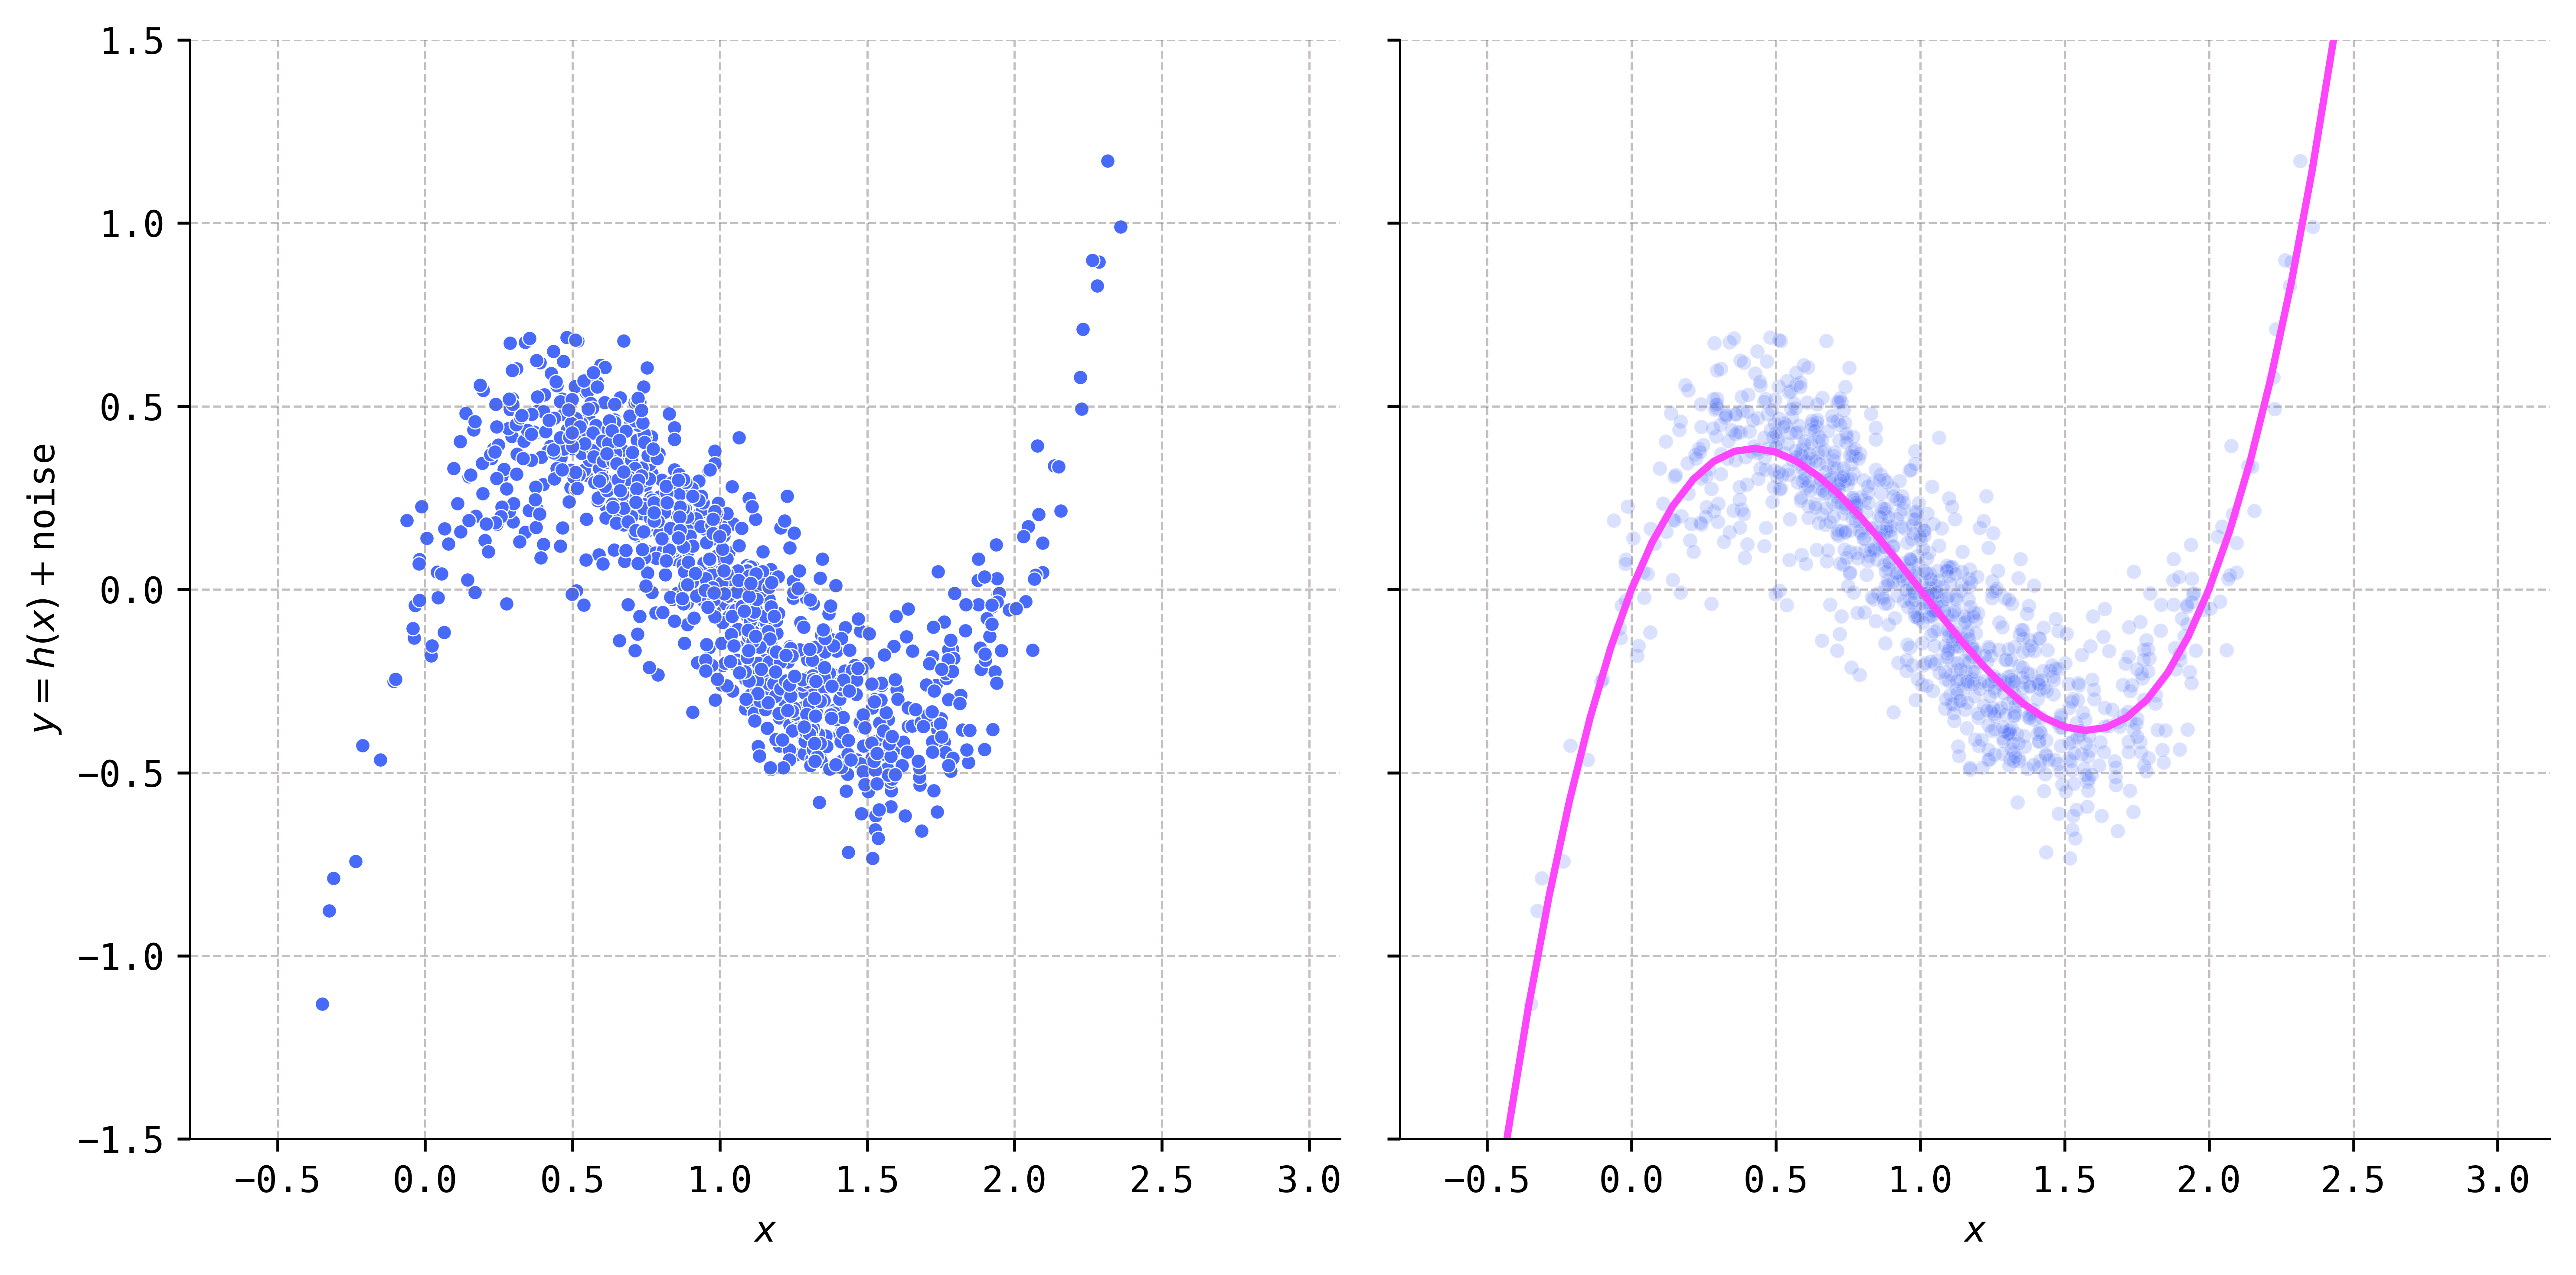

In [2]:
epsilon = norm.rvs(scale=0.15, size=1000)
mesh = np.linspace(-0.5, 3)

_, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)

sns.scatterplot(x=x, y=y + epsilon, ax=ax[0])
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y=h(x) + $noise')

sns.scatterplot(x=x, y=y + epsilon, alpha=0.2, ax=ax[1])
ax[1].plot(mesh, h(mesh), color='#FD46FC')
ax[1].set_xlabel('$x$')

plt.tight_layout()

The "noisy" functional relationship is draw in the left-hand plot, while on the right-hand plot I have superimposed the graph of the function $y=h(x)$ for reference. Instead of lying directly on the graph of $y=h(x)$, the data is instead clustered along the graph.

The goal in this chapter is to study "noisy" _linear_ dependencies between random variables; relationships that look like these:

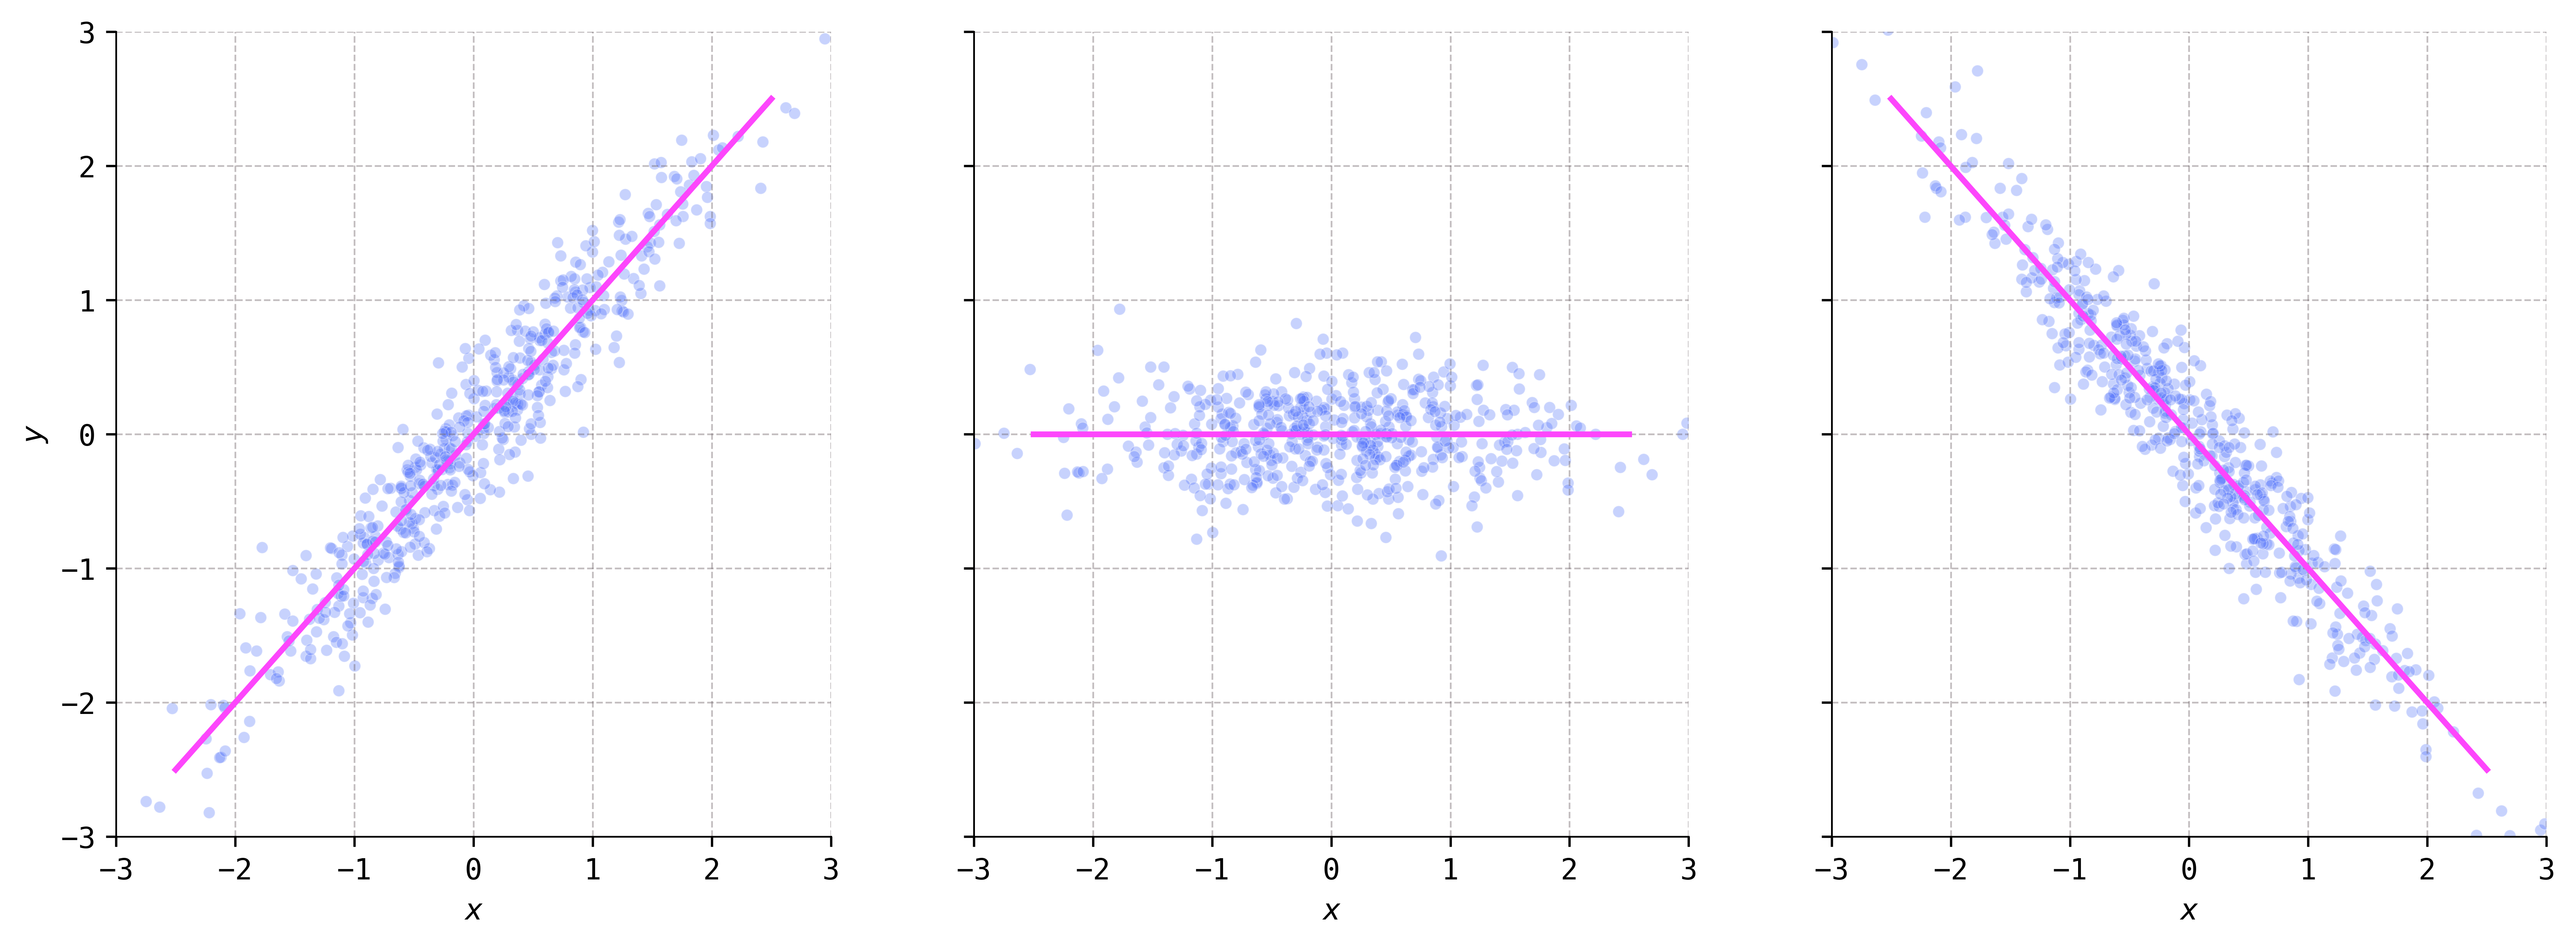

In [3]:
mesh = np.linspace(-2.5, 2.5)
epsilon = norm.rvs(scale=0.3, size=500)
m = [1, 0, -1]
x = norm.rvs(size=500)
_, ax = plt.subplots(ncols=3, figsize=(15, 5), sharey=True, sharex=True)

for i, m in enumerate(m):
    y = m * x + epsilon
    sns.scatterplot(x=x, y=y, ax=ax[i], alpha=0.3)
    ax[i].plot(mesh, m * mesh, color='#FD46FC')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')

We have _seen_ scatter plots like this before! Indeed, recall the dataset from the [beginning](motivation) of the previous chapter consisting of pairs

$$
(x_1,y_1),(x_2,y_2),\ldots,(x_{2000},y_{2000}),
$$

where $x_i$ is the size of the $i$-th house (in ft$^2$) and $y_i$ is the selling price (in $1k). This was the scatter plot of the data, with a straight line superimposed for reference:

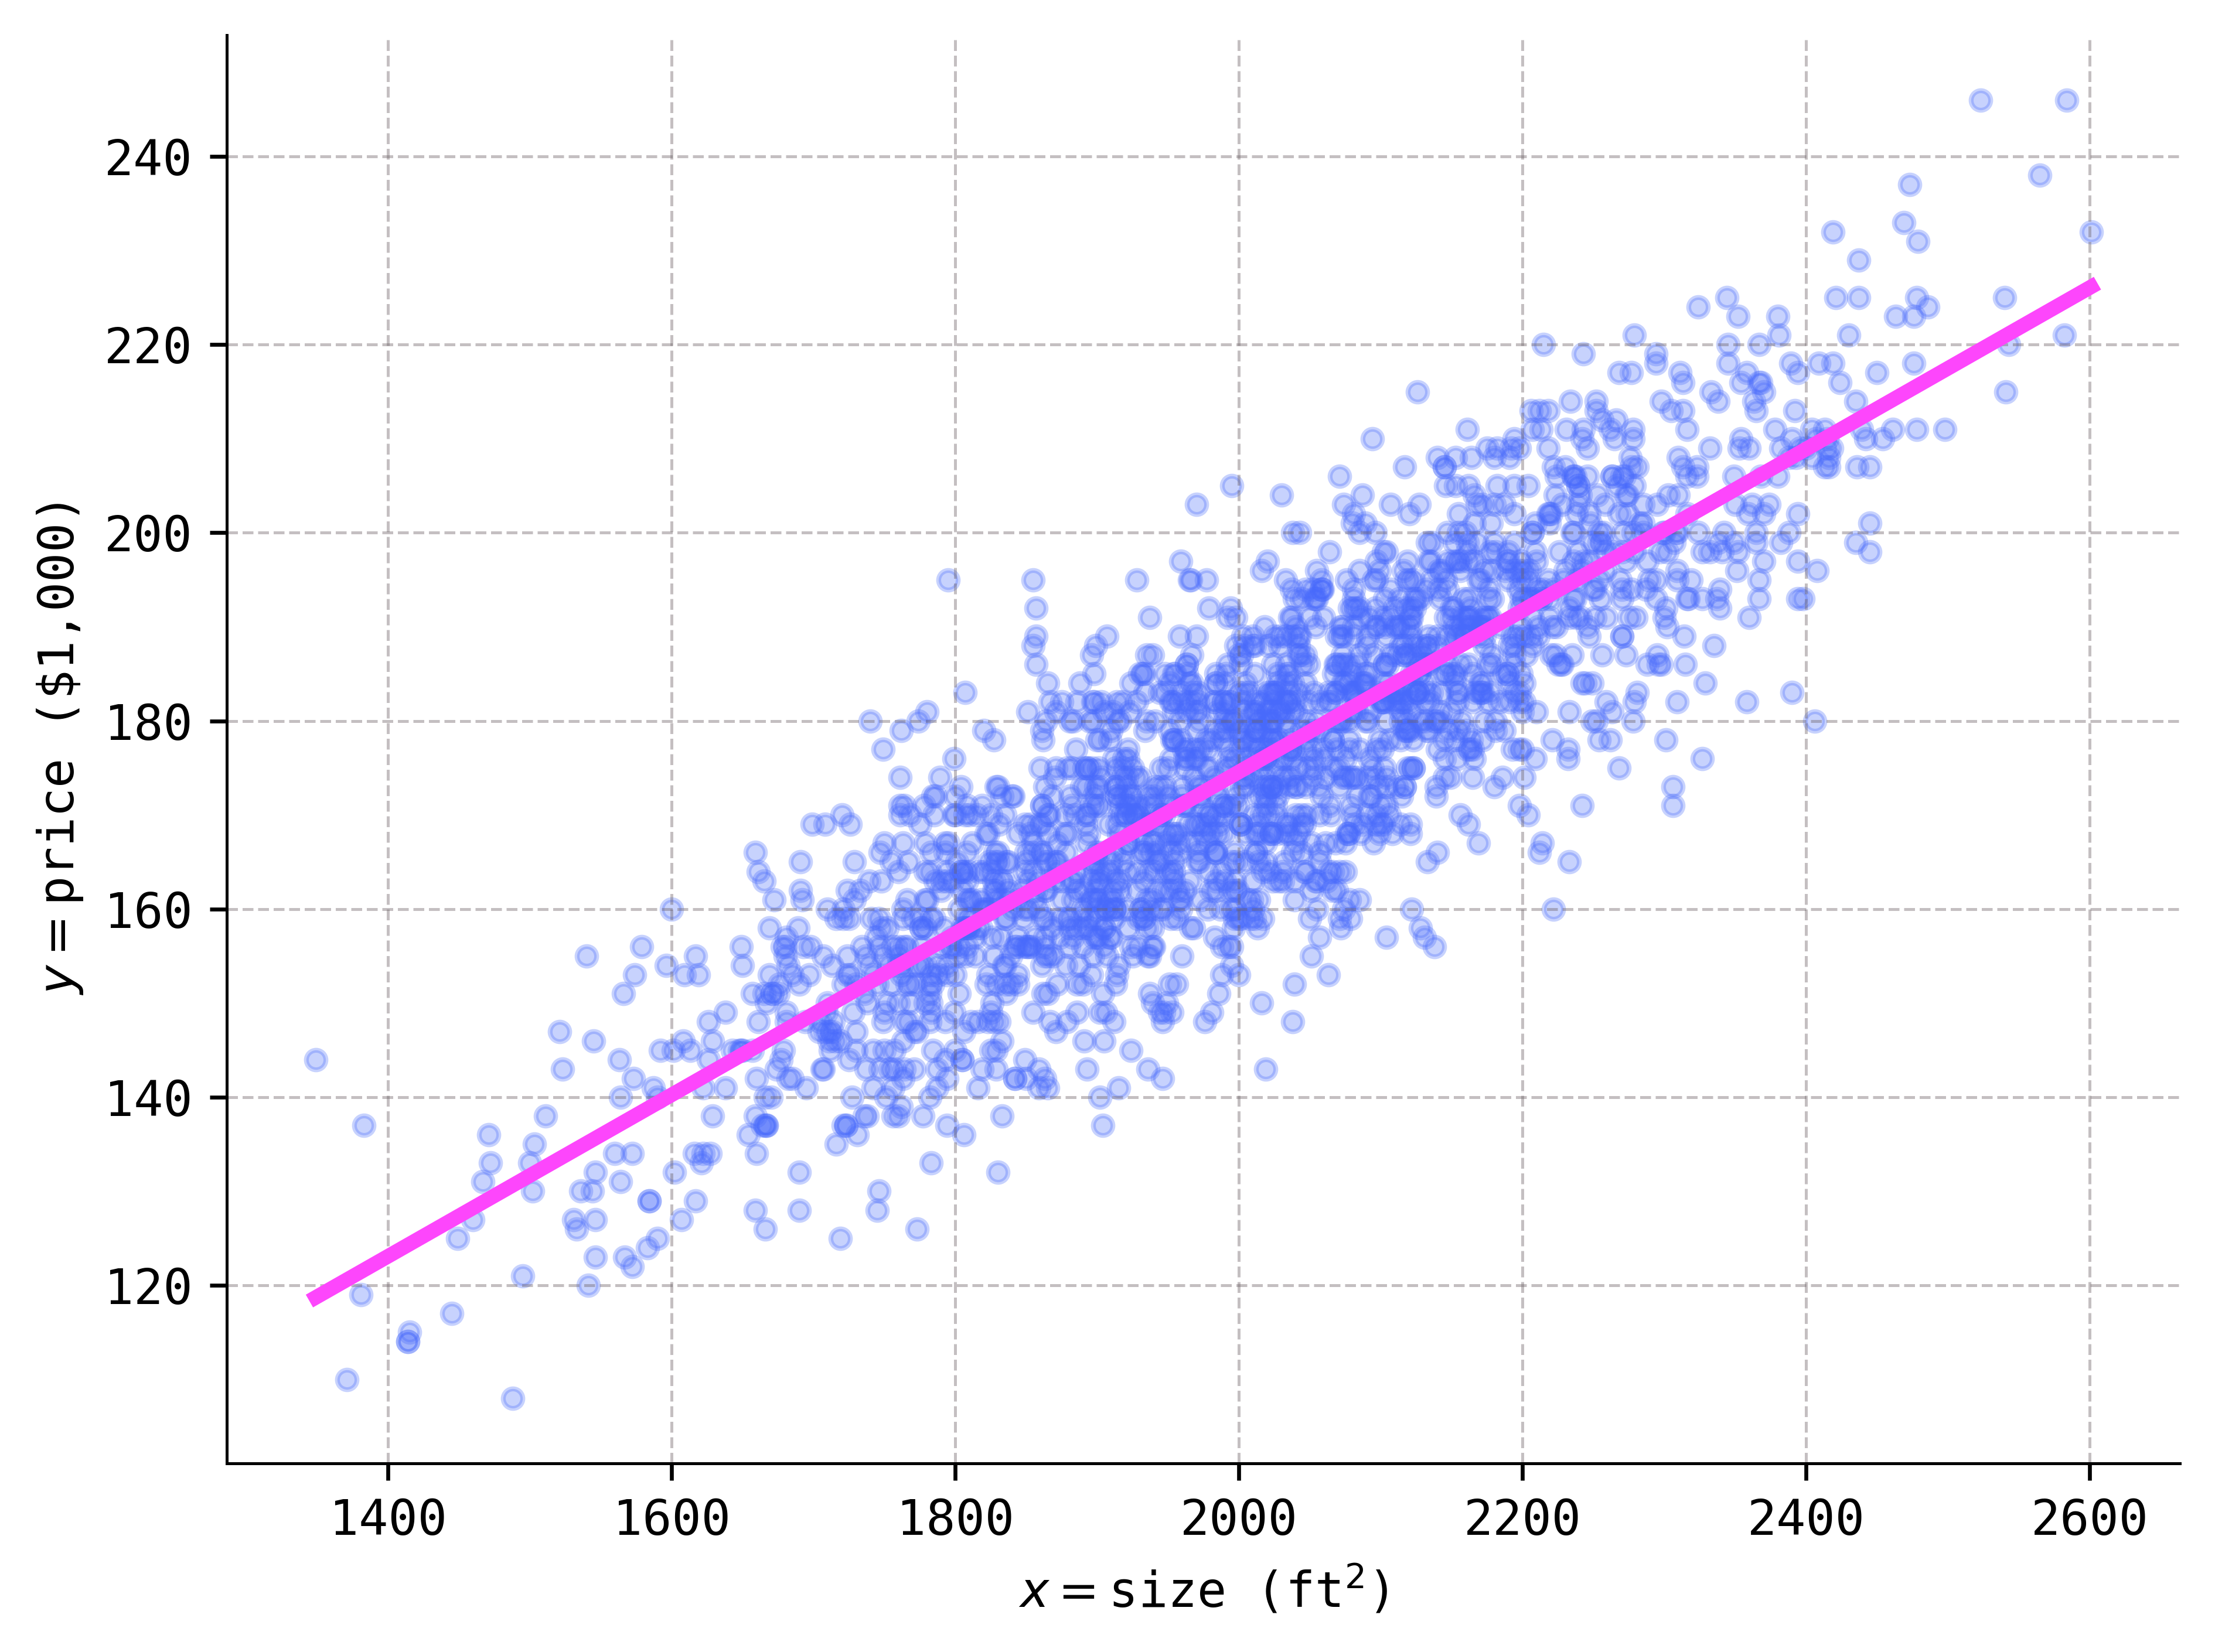

In [4]:
# data will be simulated from a multivariate gaussian.
# define the parameters
rho = 0.85
sigma_1 = 200
sigma_2 = 20
mu = np.array([2000, 175])
sigma = np.array([
    [sigma_1 ** 2, rho * sigma_1 * sigma_2],
    [rho * sigma_1 * sigma_2, sigma_2 ** 2]
])

# generate the data
data = multivariate_normal(mean=mu, cov=sigma).rvs(size=2000)
X = np.round(data[:, 0])
Y = np.round(data[:, 1])

sns.regplot(x=X, y=Y, ci=None, scatter_kws={'alpha' : 0.3}, line_kws={'color' : '#FD46FC'})
plt.xlabel('$x=$size (ft$^2$)')
plt.ylabel('$y=$price (\$1,000)')
plt.tight_layout()

```{margin}

The line in this plot that the data clusters along is called the _least-squares line_. We will study these later in the book.
```

Thus, there appears to be a "noisy" linear dependence between the size of a house $X$ and its selling price $Y$. Moreover, the line that the data naturally clusters along has positive slope, which indicates that as the size of a house increases, its selling price tends to increase as well.

In particular, our goal in this chapter is to uncover ways to _quantify_ or _measure_ the strength of "noisy" linear dependencies between random variables. We will discover that there are two such measures: _Covariance_ and _correlation_.










## Covariance

The definition of _covariance_ is based on the following pair of basic observations:

> 1. If the observed values of two random variables $X$ and $Y$ cluster along a line of _positive_ slope, then $x$ and $y$ in a data point $(x,y)$ tend to be large (and small) at the same time.
> 2. If the observed values of two random variables $X$ and $Y$ cluster along a line of _negative_ slope, then a large value $x$ tends to be paired with a small value $y$ in a data point $(x,y)$, while a small value of $x$ tends to be paired with a large value $y$.

In order to make something useful from these observations, it is convenient to "center" the dataset by subtracting off the means:

$$
X \xrightarrow{\text{replace with}} X - \mu_X \quad \text{and} \quad Y \xrightarrow{\text{replace with}} Y - \mu_Y.
$$

Notice that

$$
E(X - \mu_X) = E(X) - E(\mu_X) = 0,
$$

and similarly $E(Y-\mu_Y) = 0$, so that when we carry out these replacements, we get random variables with mean $0$. If we center the housing data by subtracting the means and then plot, we get this:

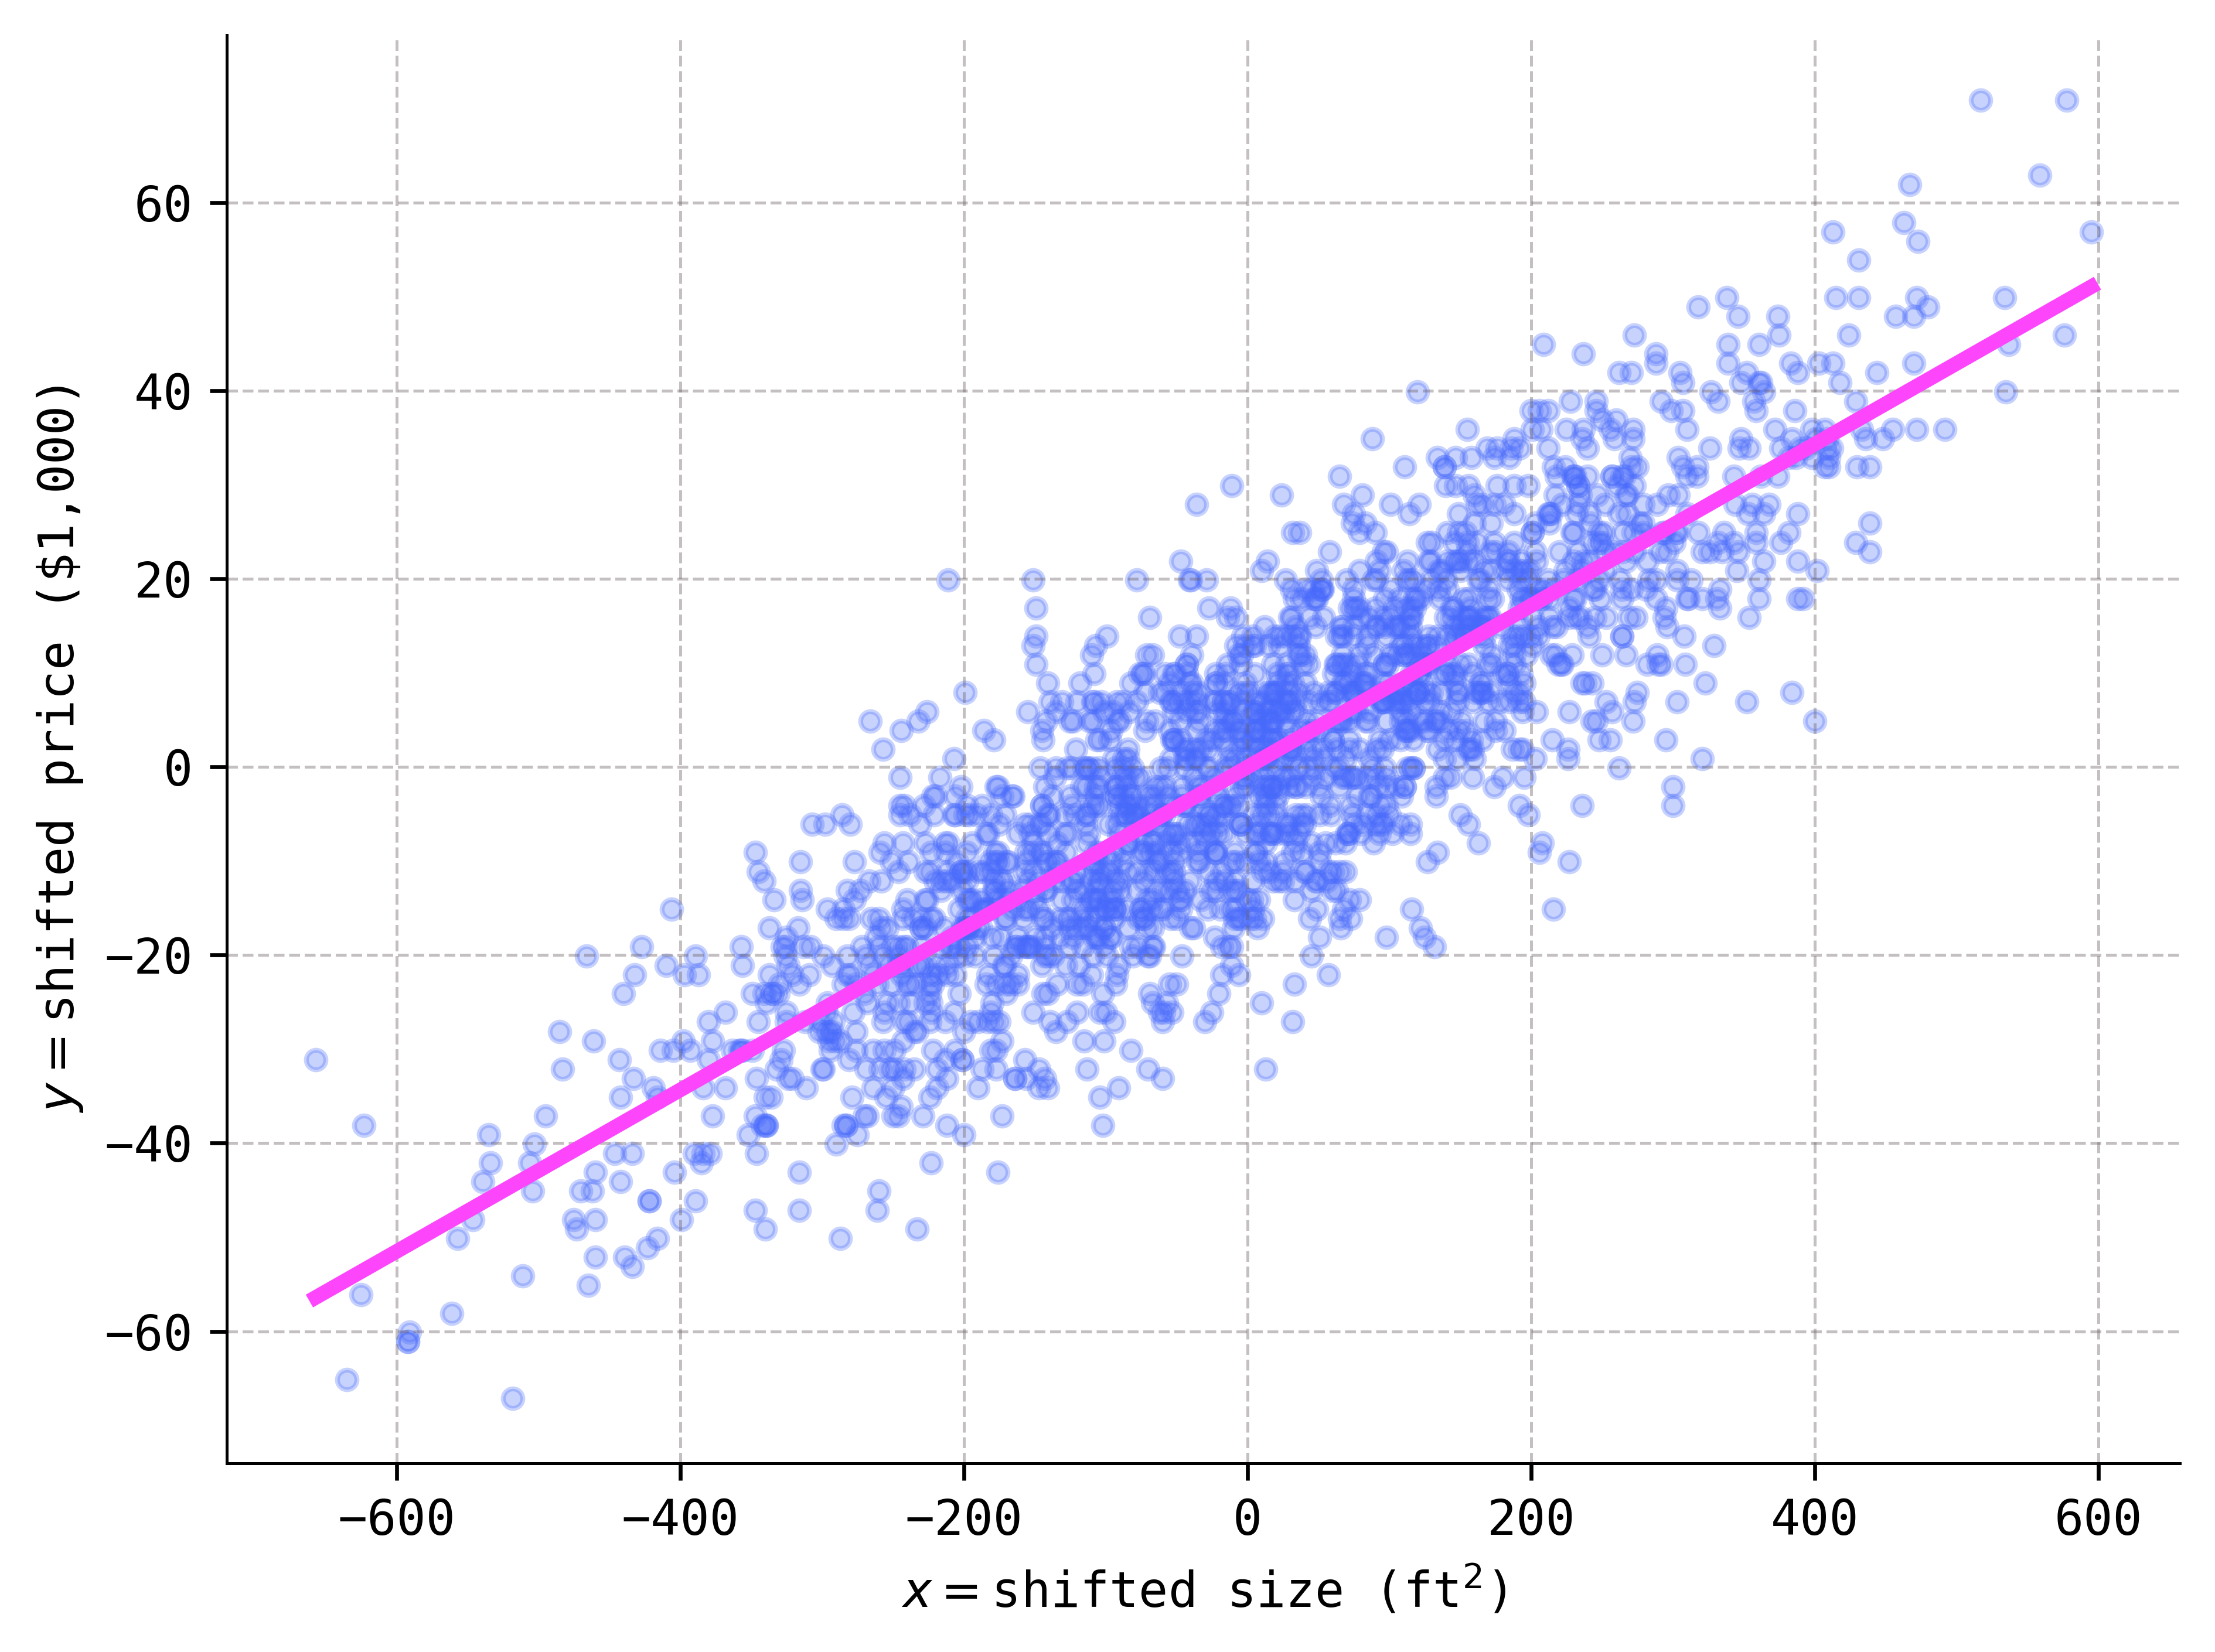

In [5]:
sns.regplot(x=X - np.mean(X), y=Y - np.mean(Y), ci=None, scatter_kws={'alpha' : 0.3}, line_kws={'color' : '#FD46FC'})
plt.xlabel('$x=$shifted size (ft$^2$)')
plt.ylabel('$y=$shifted price (\$1,000)')
plt.tight_layout()

You can see that the dataset has not changed its shape---it has only shifted so that its "center" is at the origin $(0,0)$.

The reason that we "center" the data is because it allows us to conveniently rephrase our observations above in terms of signs:

> 1. If the observed values of two **centered** random variables $X$ and $Y$ cluster along a line of _positive_ slope, then $x$ and $y$ in a data point $(x,y)$ tend to have the same sign, i.e., $xy>0$.
> 2. If the observed values of two **centered** random variables $X$ and $Y$ cluster along a line of _negative_ slope, then $x$ and $y$ in a data point $(x,y)$ tend to have opposite signs, i.e., $xy < 0$.

Now, consider the following:

```{prf:definition}

Let $X$ and $Y$ be two random variables with expectations $\mu_X = E(X)$ and $\mu_Y = E(Y)$. The _covariance_ of $X$ and $Y$, denoted $\operatorname{Cov}(X,Y)$, is defined via the equation

$$
\operatorname{Cov}(X,Y) = E \left[ (X-\mu_X)(Y-\mu_Y) \right].
$$
```

More coming soon!